In [1]:
%pylab inline

from scipy.stats.distributions import skewnorm

Populating the interactive namespace from numpy and matplotlib


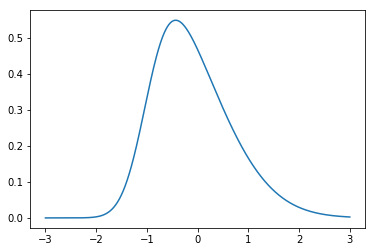

In [17]:
X = linspace(-3,3,1000)
plot(X,skewnorm.pdf(X, 3, -1, 1.2))

#hist([skewnorm.rvs(1,0) for i in xrange(100)], normed=True)

In [28]:
random.seed(0)

X = linspace(1,10,100)

x = 1+random.rand(50)*(10-1)
y = lambda x: x**0.95+0.5
mu = lambda x, m, b: m*x+b
error = array([skewnorm.rvs(3,-1,1.2) for i in xrange(x.size)])

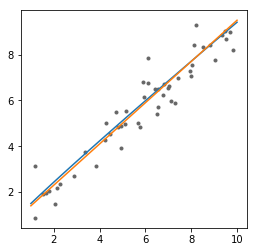

In [30]:
plot(x, y(x)+error, ".", color="0.4")
plot(X, y(X), "-", X, mu(X,0.90,0.5), "-")

gca().set_aspect("equal")